# Pool 4 TDA

## Import libraries

In [1]:
import kmapper as km
from kmapper.plotlyviz import *
import pandas as pd
import numpy as np

import sklearn
#from sklearn import ensemble
# DBSCAN from sklearn for clustering algorithms
from sklearn.cluster import DBSCAN
# PCA from sklearn for projection/lens creation
from sklearn.decomposition import PCA
# from sklearn.manifold import MDS
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

# scipy for interpolation
# import scipy 
# from scipy.interpolate import *
import hdbscan
import pickle as pk
import json as js
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer

# Plotly and Dash
import plotly.graph_objs as go
from kmapper.plotlyviz import plotlyviz
from kmapper.plotlyviz import *
from ipywidgets import (HBox, VBox)
import dash_html_components as html
import dash_core_components as dcc
import dash
from ipywidgets import interactive, HBox, VBox, widgets, interact
import warnings
warnings.filterwarnings("ignore")

## Upload data

In [2]:
water20 = pd.read_csv("../../LTRM data/RF interpolation/water_full.csv")
water20 = water20[["SHEETBAR", "DATE", "LATITUDE","LONGITUDE","FLDNUM", "STRATUM","LOCATCD",
"TN","TP","TEMP", "DO", "TURB", "VEL", "SS", "WDP", "CHLcal",  "SECCHI", "YEAR", "SEASON"]]

## Scale data

In [3]:
continuous_variables = ["WDP","SECCHI","TEMP", "DO", "TURB", "VEL", "TP", "TN", "SS", "CHLcal"]

ct = ColumnTransformer([('somename', RobustScaler(), continuous_variables)], remainder = 'passthrough')

water_df = ct.fit_transform(water20)

water_df = pd.DataFrame(water_df, columns = ["WDP","SECCHI","TEMP", "DO", "TURB", "VEL", "TP", "TN", "SS", "CHLcal",
                                             "SHEETBAR", "DATE", "LATTITUDE","LONGITUDE","FLDNUM", "STRATUM","LOCATCD",
                                             "YEAR", "SEASON"])  

## Make decade columns

In [4]:
eco_time_periods = ['1993-2000', '1898-2004', '2001-2013', '2010-2016', '2014-2020']

for time_period in eco_time_periods:
    begin_year = int(time_period[0:4])
    end_year = int(time_period[5:9])
    
    water_df[time_period] = np.where((water_df['YEAR'] >= begin_year) & (water_df['YEAR'] <= end_year), 1, 0)

## Make dummy columns

In [5]:
to_dummy_vars = ['STRATUM', 'FLDNUM']

for var in to_dummy_vars:
    temp = pd.get_dummies(water_df[var])
    water_df = pd.concat([water_df, temp], axis = 1)

## Filter for Upper and Lower pool 4

In [7]:
# Upper pool 4
pool4 = water_df[water_df['FLDNUM'] == "Lake City, MN"]

upper4 = pool4[pool4['LONGITUDE'] > -92.11 ]
upper4 = upper4[upper4['STRATUM'] != 'Impounded' ]
upper4 = upper4[upper4['STRATUM'] != 'Isolated' ]
upper4 = upper4[upper4['STRATUM'] != 'Lake Pepin or Swan Lake' ]


lower4 = pool4[pool4['LONGITUDE'] < -92.33 ]
lower4 = lower4[lower4['STRATUM'] != 'Lake Pepin or Swan Lake' ]

## Choose epsilon with curvature

In [8]:
from sklearn.neighbors import NearestNeighbors

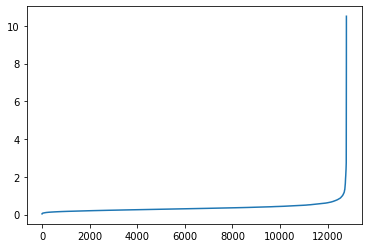

In [12]:
neighbors = NearestNeighbors(n_neighbors = 20)
neighbors_fit = neighbors.fit(pool4[continuous_variables])
distances, indices = neighbors_fit.kneighbors(pool4[continuous_variables])

distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

## Kmapper function

In [ ]:
for 
continuous_variables = ["WDP","SECCHI","TEMP", "DO", "TURB", "VEL", "TP", "TN", "SS", "CHLcal"]
X = water_df#[continuous_variables]

var_to_index = {continuous_variables[i] : i for i in range(len(continuous_variables))}
projected_var_indices = [var_to_index[var] for var in continuous_variables]

X.reset_index(drop = True, inplace = True)

cluster_alg = sklearn.cluster.DBSCAN(eps = 1.2, min_samples = 20, metric = 'euclidean')
#cluster_alg = hdbscan.HDBSCAN(min_cluster_size = 10, min_samples = 10)
pca = PCA(n_components = 2)
lens = pca.fit_transform(X[continuous_variables])

mapper = km.KeplerMapper(verbose = 0)
scomplex = mapper.map(lens, X[continuous_variables], cover = km.Cover(n_cubes = [125, 125], perc_overlap = [.4, .4]), 
                                            clusterer = cluster_alg, remove_duplicate_nodes = True)